## Contents
* read data
* drop redeundant columns
* one-hot encoding
* sliding window method
* identify response variable and predictors
* split into training and testing datasets
* data normalisation of training datasets
* define the model
* choose hyperparameters to tune
* identify the best hyperparameters using gridsearch
* make predictions based on these hyperparameters
* assess model performance 

In [32]:
import os
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, accuracy_score
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
import warnings
warnings.filterwarnings("ignore")

In [33]:
base_dir = os.path.dirname(os.path.abspath("..\data"))
path = os.path.join(base_dir, r"data")
os.chdir(path) 

In [79]:
data = pd.read_csv("Cleaned data\data.csv")
data

,YEAR,MONTH,DAY,HUMIDITY,WINDSPEED,DATE,TOTALDEMAND,HOLIDAY,MIN,MAX,RAIN,SOLAR,RRP,FORECASTDEMAND,OUTPUT,MONTHDATE,WEEKDAY,WEEKEND,TEMPAVE
0,2016,1,1,0.656341,15.902439,2016-01-01,6853.633437,2.0,15.3,28.6,0.0,32.2,38.472917,6665.366167,23.465,01-2016,4,0,21.95
1,2016,1,2,0.656341,15.902439,2016-01-02,6727.613958,0.0,15.9,26.1,0.0,21.7,36.907292,6236.849955,23.465,01-2016,5,1,21.00
2,2016,1,3,0.688837,14.488372,2016-01-03,6616.406076,0.0,17.5,25.6,0.0,10.3,31.997083,6551.924748,23.465,01-2016,6,1,21.55
3,2016,1,4,0.679545,22.477273,2016-01-04,7367.750278,0.0,18.2,23.6,14.0,6.4,33.424583,6729.993123,23.465,01-2016,0,0,20.90
4,2016,1,5,0.768837,22.581395,2016-01-05,7462.242014,0.0,17.6,20.5,39.0,4.4,33.053958,7333.898202,23.465,01-2016,1,0,19.05
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2371,2022,7,28,0.570217,21.608696,2022-07-28,8712.672500,0.0,6.2,19.7,0.0,12.8,114.477308,8782.902714,183.255,07-2022,3,0,12.95
2372,2022,7,29,0.594186,16.209302,2022-07-29,8850.636146,0.0,6.8,16.8,0.0,13.0,109.037174,9082.919122,183.255,07-2022,4,0,11.80
2373,2022,7,30,0.585238,24.642857,2022-07-30,8601.131632,0.0,3.6,16.7,0.0,13.1,74.349286,8721.769989,183.255,07-2022,5,1,10.15
2374,2022,7,31,0.643333,12.769231,2022-07-31,8699.873889,0.0,2.6,18.0,0.0,10.6,123.749503,8602.762027,183.255,07-2022,6,1,10.30


In [70]:
# drop columns
df = data.drop(columns=[
    "DATE","FORECASTDEMAND","MONTHDATE","MIN","ACCMIN","MAX","ACCMAX","RAINPERIOD","QUANTITY","QUANTITYMONTHCUM","QUANTITYTOTALCUM","HUMIDITYMIN","HUMIDITYMAX", "RAIN", "WEEKEND"
], errors="ignore")
df.head()

,YEAR,MONTH,DAY,HUMIDITY,WINDSPEED,TOTALDEMAND,HOLIDAY,SOLAR,RRP,OUTPUT,WEEKDAY,TEMPAVE
0,2016,1,1,0.656341,15.902439,6853.633437,2.0,32.2,38.472917,23.465,4,21.95
1,2016,1,2,0.656341,15.902439,6727.613958,0.0,21.7,36.907292,23.465,5,21.00
2,2016,1,3,0.688837,14.488372,6616.406076,0.0,10.3,31.997083,23.465,6,21.55
3,2016,1,4,0.679545,22.477273,7367.750278,0.0,6.4,33.424583,23.465,0,20.90
4,2016,1,5,0.768837,22.581395,7462.242014,0.0,4.4,33.053958,23.465,1,19.05


In [71]:
#one hot encoding weekday
def one_hot_encode(df, col, names):
    array = np.array(df[col])
    integer_encoded = array.reshape(len(array), 1)
    onehotencoder = OneHotEncoder()
    onehot_encoded = onehotencoder.fit_transform(integer_encoded).toarray()
    df_encoded = pd.DataFrame(onehot_encoded, columns=names)
    df = pd.concat([df, df_encoded], axis=1)
    df = df.drop(columns=[col], errors="ignore")
    return df

df = one_hot_encode(df, col="WEEKDAY", names=['MON', 'TUE', 'WED', 'THU', 'FRI', 'SAT', 'SUN'])
df.head()

,YEAR,MONTH,DAY,HUMIDITY,WINDSPEED,TOTALDEMAND,HOLIDAY,SOLAR,RRP,OUTPUT,TEMPAVE,MON,TUE,WED,THU,FRI,SAT,SUN
0,2016,1,1,0.656341,15.902439,6853.633437,2.0,32.2,38.472917,23.465,21.95,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,2016,1,2,0.656341,15.902439,6727.613958,0.0,21.7,36.907292,23.465,21.00,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,2016,1,3,0.688837,14.488372,6616.406076,0.0,10.3,31.997083,23.465,21.55,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,2016,1,4,0.679545,22.477273,7367.750278,0.0,6.4,33.424583,23.465,20.90,1.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2016,1,5,0.768837,22.581395,7462.242014,0.0,4.4,33.053958,23.465,19.05,0.0,1.0,0.0,0.0,0.0,0.0,0.0


In [72]:
# function to create the sliding window dataset
def create_sliding_window(data, window_size, step_size, target):
    X = []
    y = []
    for i in range(window_size, len(data)):
        X_window = []
        for j in range(0, window_size, step_size):
            X_window.append(data.iloc[i-j-1, :])
        X.append(np.concatenate(X_window, axis=0))
        y.append(data.iloc[i, :]) 
    y2 = [vals[5] for vals in y]
    # display(pd.DataFrame(X))
    return pd.DataFrame(X), pd.DataFrame(y2)

In [73]:
# Define the window size and step size
target = "TOTALDEMAND"
window_size = 1   # 1 day ahead
step_size = 1     # move the window by 1 day at a time

# Apply the sliding window method
X, y = create_sliding_window(df, window_size, step_size, target)
X_all = X.copy()
X = X.iloc[:, 1:]
X

,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17
0,1.0,1.0,0.656341,15.902439,6853.633437,2.0,32.2,38.472917,23.465,21.95,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,1.0,2.0,0.656341,15.902439,6727.613958,0.0,21.7,36.907292,23.465,21.00,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,1.0,3.0,0.688837,14.488372,6616.406076,0.0,10.3,31.997083,23.465,21.55,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,1.0,4.0,0.679545,22.477273,7367.750278,0.0,6.4,33.424583,23.465,20.90,1.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1.0,5.0,0.768837,22.581395,7462.242014,0.0,4.4,33.053958,23.465,19.05,0.0,1.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2370,7.0,27.0,0.693953,23.093023,8834.442083,0.0,12.8,105.174348,183.255,13.55,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2371,7.0,28.0,0.570217,21.608696,8712.672500,0.0,12.8,114.477308,183.255,12.95,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2372,7.0,29.0,0.594186,16.209302,8850.636146,0.0,13.0,109.037174,183.255,11.80,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2373,7.0,30.0,0.585238,24.642857,8601.131632,0.0,13.1,74.349286,183.255,10.15,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [39]:
# train test split - use last year to train (data ends in 08/2022 so set timeframe as 08/2021 to 08/2022)
test_timeframe = df.loc[np.where(((df['YEAR'] == 2021) & (df['MONTH'] > 7)) | (df['YEAR'] == 2022))]
test_len = len(test_timeframe)
X_train, X_test = X.head(len(X)-test_len), X.tail(test_len)
y_train, y_test = y.head(len(X)-test_len), y.tail(test_len)

In [40]:
# define scaler and transform data
scaler = MinMaxScaler()
X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train))
X_test_scaled = pd.DataFrame(scaler.fit_transform(X_test))

In [41]:
# Define the XGBoost model
model = xgb.XGBRegressor()

In [42]:
# hyperparameters
params = {
    'max_depth': [1, 2, 3, 4],
    'learning_rate': [0.2, 0.1, 0.05],
    'n_estimators': [150, 170, 180, 200, 220]
}

In [43]:
# identify best hyperparameters using gridsearch
grid = GridSearchCV(model, params, cv=5, n_jobs=-1)
grid.fit(X_train_scaled, y_train) 

GridSearchCV(cv=5,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False, eval_metric=None,
                                    gamma=None, gpu_id=None, grow_policy=None,
                                    importance_type=None,
                                    interaction_constraints=None,
                                    learning_rate=None, max_bin=None,
                                    max_cat...None, max_delta_step=None,
                                    max_depth=None, max_leaves=None,
                                    min_child_weight=None, missing=nan,
                                    monotone_constraints=None, n_estimators=100,
        

In [44]:
# best hyperparameters and score
print("Best Hyperparameters: ", grid.best_params_)
print("Best Score: ", grid.best_score_) 

Best Hyperparameters:  {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 150}
Best Score:  0.8183182349896558


In [45]:
# # print all results 
# print("------ All Results ------- ")
# means = grid.cv_results_['mean_test_score']
# stds = grid.cv_results_['std_test_score']
# for mean, std, params in zip(means, stds, grid.cv_results_['params']):
#     print("   %0.3f (+/-%0.03f) for %r" % (mean, std * 2, params))
# print("------ End All Results ------- ") 

In [46]:
# train model using best hyperparameters
best_model = grid.best_estimator_
best_model.fit(X_train_scaled, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.1, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=3, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=150, n_jobs=0,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, ...)

In [47]:
# predictions on test data 
y_pred = best_model.predict(X_test_scaled)

In [54]:
# print model performance
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print("Mean Absolute Error: {:.2f}".format(mae))
print("Root Mean Squared Error: {:.2f}".format(rmse))
print("R Squared: {:.2f}".format(r2)) 

Mean Absolute Error: 322.48
Root Mean Squared Error: 404.43
R Squared: 0.69


#### Plot Accuracy

In [55]:
import matplotlib.pyplot as plt 
import matplotlib.dates as mdates
import datetime as dt

In [ ]:
df_lim = df.tail(test_len)

In [85]:
df_lim = X_all.tail(test_len)
df_lim.columns = df.columns
df_lim["YTEST"] = y_test
df_lim["YPRED"] = y_pred
df_lim["DATE"] = pd.to_datetime(dict(year=df.YEAR, month=df.MONTH, day=df.DAY))
df_lim["FORECAST"] = data["FORECASTDEMAND"].tail(test_len).shift(-1)
df_lim = df_lim.dropna()
df_lim

,YEAR,MONTH,DAY,HUMIDITY,WINDSPEED,TOTALDEMAND,HOLIDAY,SOLAR,RRP,OUTPUT,...,TUE,WED,THU,FRI,SAT,SUN,YTEST,YPRED,DATE,FORECAST
2039,2021.0,8.0,1.0,0.574894,23.255319,7335.822396,0.0,9.5,47.296000,73.480,...,0.0,0.0,0.0,0.0,0.0,1.0,8101.526979,8187.269043,2021-08-01,8327.524223
2040,2021.0,8.0,2.0,0.574894,23.255319,8101.526979,2.0,12.3,55.460417,73.480,...,0.0,0.0,0.0,0.0,0.0,0.0,8077.243715,8792.900391,2021-08-02,8331.968164
2041,2021.0,8.0,3.0,0.647174,17.065217,8077.243715,0.0,13.2,44.100417,73.480,...,1.0,0.0,0.0,0.0,0.0,0.0,8461.227500,8423.101562,2021-08-03,8662.525274
2042,2021.0,8.0,4.0,0.602083,22.562500,8461.227500,0.0,13.6,58.249787,73.480,...,0.0,1.0,0.0,0.0,0.0,0.0,8231.809201,8771.986328,2021-08-04,8467.645334
2043,2021.0,8.0,5.0,0.484889,29.066667,8231.809201,0.0,13.8,46.115417,73.480,...,0.0,0.0,1.0,0.0,0.0,0.0,8027.316944,8541.299805,2021-08-05,8193.368153
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2370,2022.0,7.0,27.0,0.693953,23.093023,8834.442083,0.0,12.8,105.174348,183.255,...,0.0,1.0,0.0,0.0,0.0,0.0,8712.672500,9205.852539,2022-07-27,8782.902714
2371,2022.0,7.0,28.0,0.570217,21.608696,8712.672500,0.0,12.8,114.477308,183.255,...,0.0,0.0,1.0,0.0,0.0,0.0,8850.636146,9062.476562,2022-07-28,9082.919122
2372,2022.0,7.0,29.0,0.594186,16.209302,8850.636146,0.0,13.0,109.037174,183.255,...,0.0,0.0,0.0,1.0,0.0,0.0,8601.131632,8599.184570,2022-07-29,8721.769989
2373,2022.0,7.0,30.0,0.585238,24.642857,8601.131632,0.0,13.1,74.349286,183.255,...,0.0,0.0,0.0,0.0,1.0,0.0,8699.873889,8661.786133,2022-07-30,8602.762027


In [89]:
Date = [d.date() for d in df_lim.DATE]
Demand = df_lim.TOTALDEMAND
Forecast = df_lim.FORECAST.replace(0, np.nan)
Pred = df_lim.YPRED
Test = df_lim.YTEST

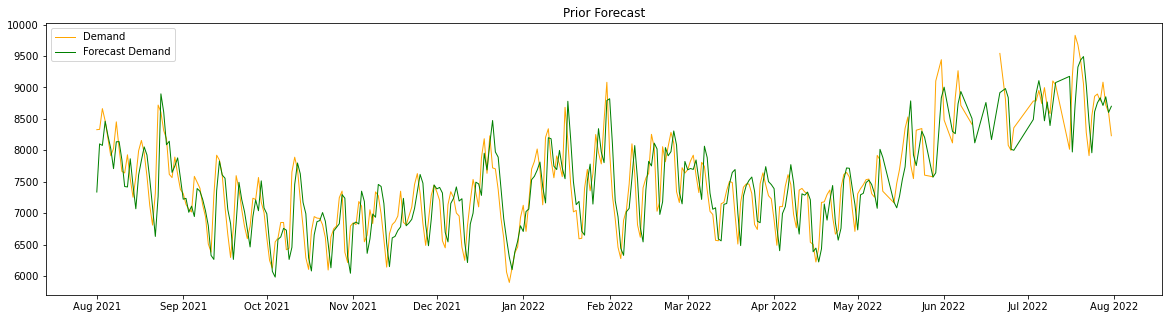

In [94]:
fig, ax = plt.subplots(figsize=(20,5))
forecast = ax.plot(Date, Forecast, linewidth=1, color='orange')
demand = ax.plot(Date, Demand, linewidth=1, color='green')
ax.legend([demand, forecast], labels=["Demand", "Forecast Demand"])
ax.xaxis.set_major_locator(mdates.MonthLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
ax.set_title("Prior Forecast")
plt.show()

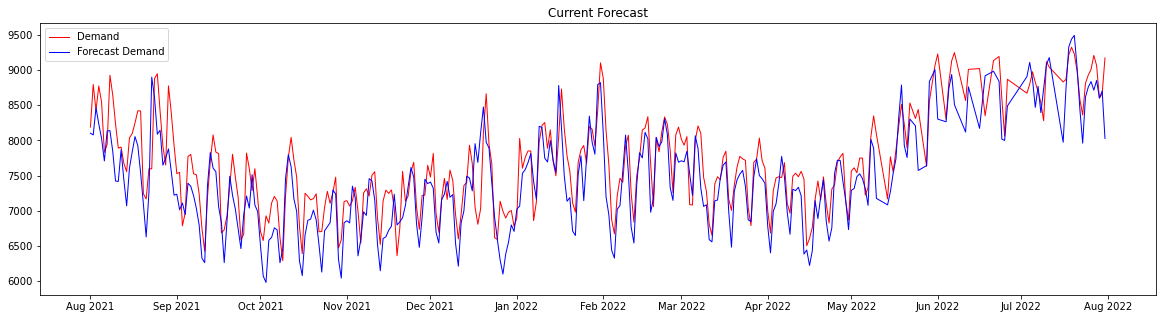

In [95]:
fig, ax = plt.subplots(figsize=(20,5))
forecast = ax.plot(Date, Pred, linewidth=1, color='red')
demand = ax.plot(Date, Test, linewidth=1, color='blue')
ax.legend([demand, forecast], labels=["Demand", "Forecast Demand"])
ax.xaxis.set_major_locator(mdates.MonthLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
ax.set_title("Current Forecast")
plt.show()